<a href="https://colab.research.google.com/github/Hyu-waseda/zemi/blob/main/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

参考<br>
https://www.slideshare.net/hoxo_m/prophet-facebook-76285278

https://qiita.com/tchih11/items/42fc0d52a1486ba64b5d

# Prophetの使い方まとめ
① 大量のビジネス時系列に対してデフォルト設定で予測を作成<br>
② SHF(Simulated Historical Forecast)による評価で順位をつけ、悪い方から順番にドメイン知識で精度改善<br>
③ それでも悪ければ専門家が予測を行う<br>
→限りあるリソースの有効活用

## デフォルト設定で流れを確認。

In [2]:
# %pip install fbprophet

In [3]:
import pandas as pd
from fbprophet import Prophet
from fbprophet import plot
from fbprophet.diagnostics import cross_validation, performance_metrics


ペイトンマニング（アメフト選手）のWikipediaのアクセス数のデータを使用。<br>
Prophetでモデリングをする際は、<br>
- s：日付データ
- y：予測したいデータ
<br>の二つのカラムが必須となる

In [59]:
# アメフト選手のWikipedeaアクセス数のデータの読み込み
# 3000日分の時系列データ

import pandas as pd
import numpy as np
# df = pd.read_csv("example_wp_peyton_manning.csv")
df = pd.read_csv('./zikeiretubunseki_owarine.csv')
# df["y"] = np.log(df["y"])


In [60]:
df.head()

ds          y         始値         高値         安値      出来高   変化率 %
0  2022年06月24日  26,491.97  26,228.42  26,519.16  26,148.56  726.41M   1.23%
1  2022年06月23日  26,171.25  26,134.89  26,401.97  26,039.57  656.83M   0.08%
2  2022年06月22日  26,149.55  26,441.72  26,462.83  26,149.17  663.69M  -0.37%
3  2022年06月21日  26,246.31  26,070.92  26,418.84  25,972.28  653.59M   1.84%
4  2022年06月20日  25,771.22  26,156.62  26,156.62  25,520.23  721.76M  -0.74%

In [61]:
#年月日のフォーマット変更
for i in range(len(df["ds"])):
  df["ds"][i] = df["ds"][i].replace("年", "-")
  df["ds"][i] = df["ds"][i].replace("月", "-")
  df["ds"][i] = df["ds"][i].replace("日", "")

#終値のフォーマット変更終値のフォーマット変更
for i in range(len(df["y"])):
  df["y"][i] = df["y"][i].replace(",", "")


In [62]:
# 予測モデルの作成
from fbprophet import Prophet
model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [66]:
# 1年の空のデータフレームを用意
future_df = model.make_future_dataframe(730)
future_df.tail()

ds
5672 2024-06-19
5673 2024-06-20
5674 2024-06-21
5675 2024-06-22
5676 2024-06-23

In [67]:
# 予測の作成。勝手に埋めてくれる。
forecast_df = model.predict(future_df)
forecast_df[["ds", "yhat"]]

ds          yhat
0    2002-05-27  10085.532796
1    2002-05-28  10089.765086
2    2002-05-29  10101.834918
3    2002-05-30  10096.799044
4    2002-05-31  10110.559665
...         ...           ...
5672 2024-06-19  32159.201767
5673 2024-06-20  32149.587241
5674 2024-06-21  32160.436187
5675 2024-06-22  33067.507822
5676 2024-06-23  31997.215233

[5677 rows x 2 columns]

In [68]:
# plotlyでプロット
from fbprophet import plot
plot.plot_plotly(model, forecast_df)

Prophetのモデル式は、トレンド＋季節＋イベント＋誤差で表される。<br>
`plot.plot_components_plotly`を使用することで、予測値を各要素(年次、週次、トレンド)に分解してプロットすることができる。

In [29]:
# 要素別の予測値プロット
plot.plot_components_plotly(model, forecast_df)

## ドメイン知識を用いる。

### トレンドの選択

In [ ]:
# 非線形トレンドの指定
# dfに予測の上限値(cap)、下限値(floor)カラムを予め追加
from fbprophet import Prophet
model = Prophet(growth="logistic")
df["cap"] = 8.5
# df["floor"] = 0
model.fit(df)
future_df = model.make_future_dataframe(365*5)
# 予測用データフレームにもcapとfloorカラムが必要
future_df["cap"] = 8.5
# df["floor"] = 0
forecast_df = model.predict(future_df)
forecast_df.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds     trend  cap  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2007-12-10  7.697449  8.5    7.778943    9.186853     7.697449     7.697449   
1 2007-12-11  7.698135  8.5    7.600098    8.910310     7.698135     7.698135   
2 2007-12-12  7.698820  8.5    7.399720    8.748933     7.698820     7.698820   
3 2007-12-13  7.699505  8.5    7.300735    8.754524     7.699505     7.699505   
4 2007-12-14  7.700189  8.5    7.335236    8.748912     7.700189     7.700189   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0        0.808138              0.808138              0.808138  0.351873   
1        0.562142              0.562142              0.562142  0.121222   
2        0.361259              0.361259              0.361259 -0.065145   
3        0.340470              0.340470              0.340470 -0.072668   
4        0.331823              0.331823              0.331823 -0.069687   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0      0.351873      0.351873  0.456265      0.456265      0.456265   
1      0.121222      0.121222  0.440920      0.440920      0.440920   
2     -0.065145     -0.065145  0.426404      0.426404      0.426404   
3     -0.072668     -0.072668  0.413138      0.413138      0.413138   
4     -0.069687     -0.069687  0.401510      0.401510      0.401510   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper      yhat  
0                         0.0  8.505586  
1                         0.0  8.260276  
2                         0.0  8.060079  
3                         0.0  8.039975  
4                         0.0  8.032012

予測値の上限は8.5

In [ ]:
from fbprophet import plot
plot.plot_plotly(model, forecast_df)

### 変化点の指定

In [ ]:
# changepoints=日付の配列
from fbprophet import Prophet
from fbprophet import plot
model = Prophet(changepoints=["2013-01-31"])
model.fit(df)
future_df = model.make_future_dataframe(365*5)
future_df["cap"] = 8.5
forecast_df = model.predict(future_df)
plot.plot_plotly(model, forecast_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


デフォルトでは、データの前半80%を使用して25個のトレンド変化点候補を均等に配置し、変化量が一定量以上の点を変化点として扱う。80%、25個、という数値はそれぞれchangepoint_range 、n_changepointsで変更可能。

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


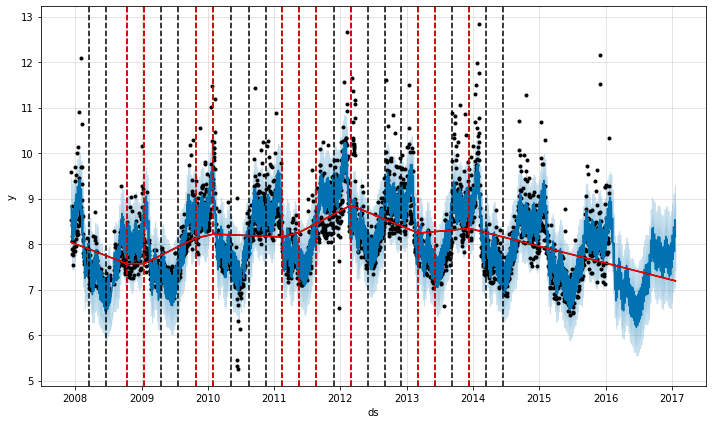

In [ ]:
# 変換点の数を指定(自動検出)
# n_changepoints=変化点の数
from fbprophet import Prophet
from fbprophet import plot
model = Prophet(changepoint_range=0.8, n_changepoints=25) # ここの値を変更
model.fit(df)

# 予測値を格納するためのDataFrameを作成
future_df = model.make_future_dataframe(periods=365)

# 予測
forecast_df = model.predict(future_df)

# 変化点の可視化
# 変化点として採用されたが赤、変化量が微量のため不採用なのが黒
fig = model.plot(forecast_df)

# 不採用となった候補点のplotが不要な場合は1つ目をコメントアウト
a = plot.add_changepoints_to_plot(fig.gca(), model, forecast_df, threshold=0, cp_color="black")
a = plot.add_changepoints_to_plot(fig.gca(), model, forecast_df)

設定されたchangepointと変化量は下記のコードで確認可能。

In [ ]:
changepoints_delta = pd.DataFrame(
    {
        "changepoints":model.changepoints,
        "delta":model.params["delta"][0]
     }
)
changepoints_delta.head()

changepoints         delta
93    2008-03-17 -2.010867e-07
186   2008-06-20 -3.918640e-08
279   2008-10-11  3.488176e-01
372   2009-01-14  4.636770e-01
465   2009-04-17 -2.285940e-09

### 週周期と年周期

In [ ]:
# それぞれの周期を考慮するか指定できる。デフォルトは"auto"
from fbprophet import Prophet
model = Prophet(weekly_seasonality=False,
                yearly_seasonality=True)
model.fit(df)
future_df = model.make_future_dataframe(365*5)
future_df["cap"] = 8.5
forecast_df = model.predict(future_df)
plot.plot_plotly(model, forecast_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### イベント効果

　シーズンオフ、シーズン中といった他の要素に依存する季節変動と予測因子を追加する際は、元のDataFrameにカラムを追加する。<br>　他の要素に依存する季節変動はbool型、因子は数値型である必要がある。

In [ ]:
# 季節変動と予測因子を設定する例

import pandas as pd
# シーズン中かどうか
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 2)
  

# 試合が開催される日曜日フラグ
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0

df['on_season'] = df['ds'].apply(is_nfl_season)
df['nfl_sunday'] = df['ds'].apply(nfl_sunday)

イベント要素を追加するためには別途下記の要素で構成されるDataFrameを用意する必要がある。<br>
- ds:日時
- holiday:イベント名
- lower_window:イベントの影響範囲（3なら3日前から影響）
- upper_window:イベントの影響範囲（3なら3日後まで影響）


祝日に関してはadd_country_holidaysというメソッドが用意されているので、自分で作る必要はない(日本はずれている可能性あり)

In [ ]:
# アメフトのスーバーボウルとプレーオフをDataFrameに格納した際の例
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((superbowls,playoffs)).reset_index(drop=True)

要素を追加した上での学習。`holidays_prior_scale`で各要素がモデルに与える影響度を調整

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


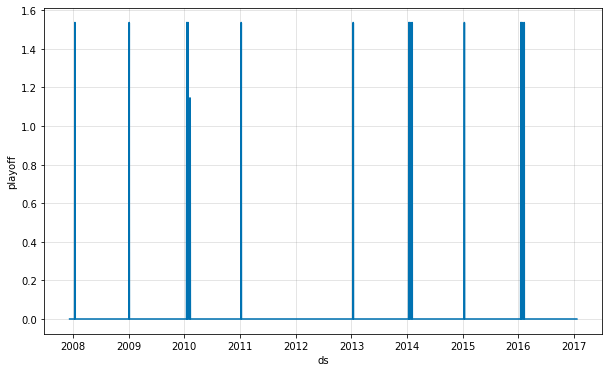

In [ ]:
from fbprophet import Prophet
from fbprophet import plot
# イベントの追加
model = Prophet(holidays=holidays, holidays_prior_scale=0.05)

# 祝日の追加はメソッドが用意されている
model.add_country_holidays(country_name='US') # 日本はJP

# 年次、週次以外の季節変動要素の追加
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# 他の要素に依存する季節変動(condition_nameに対応するカラム名)
model.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season', prior_scale=0.1)

# 因子の追加
model.add_regressor('nfl_sunday')

model.fit(df)

# 予測値を格納するためのDataFrameを作成
future_df = model.make_future_dataframe(periods=365)

# 追加したカラムは予測用DataFrameにも必要
future_df['on_season'] = future_df['ds'].apply(is_nfl_season)
future_df['nfl_sunday'] = future_df['ds'].apply(nfl_sunday)

# 予測
forecast_df = model.predict(future_df)

# 指定したイベントの可視化。3つ目の引数にイベント名を入れる
plot.plot_forecast_component(model, forecast_df, 'playoff')

季節変動を情報的モデルへ変更。<br>
季節パターンの大きさがyの大きさに比例する（yの値が大きければ季節変動の振れ幅も大きくなる）場合は乗法的モデル、それ以外の場合は加法的モデルを使用する。

In [ ]:
# 季節変動を乗法的モデルへ変更
model = Prophet(seasonality_mode='multiplicative')
model.fit(df)
# 予測値を格納するためのDataFrameを作成
future_df = model.make_future_dataframe(periods=365)
# 予測
forecast_df = model.predict(future_df)

plot.plot_plotly(model, forecast_df)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## 検証と誤差の評価

### クロスバリデーションの実行
`cross_validation`というメソッドを使用することクロスバリデーションが可能。

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')

INFO:fbprophet:Making 11 forecasts with cutoffs between 2010-02-15 00:00:00 and 2015-01-20 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

`initial`は訓練期間の初期値、`horizon`は予測する期間を表します。そして`period`で指定した日数分ずつ、学習期間が延ばすことをデータがなくなるまで繰り返す。

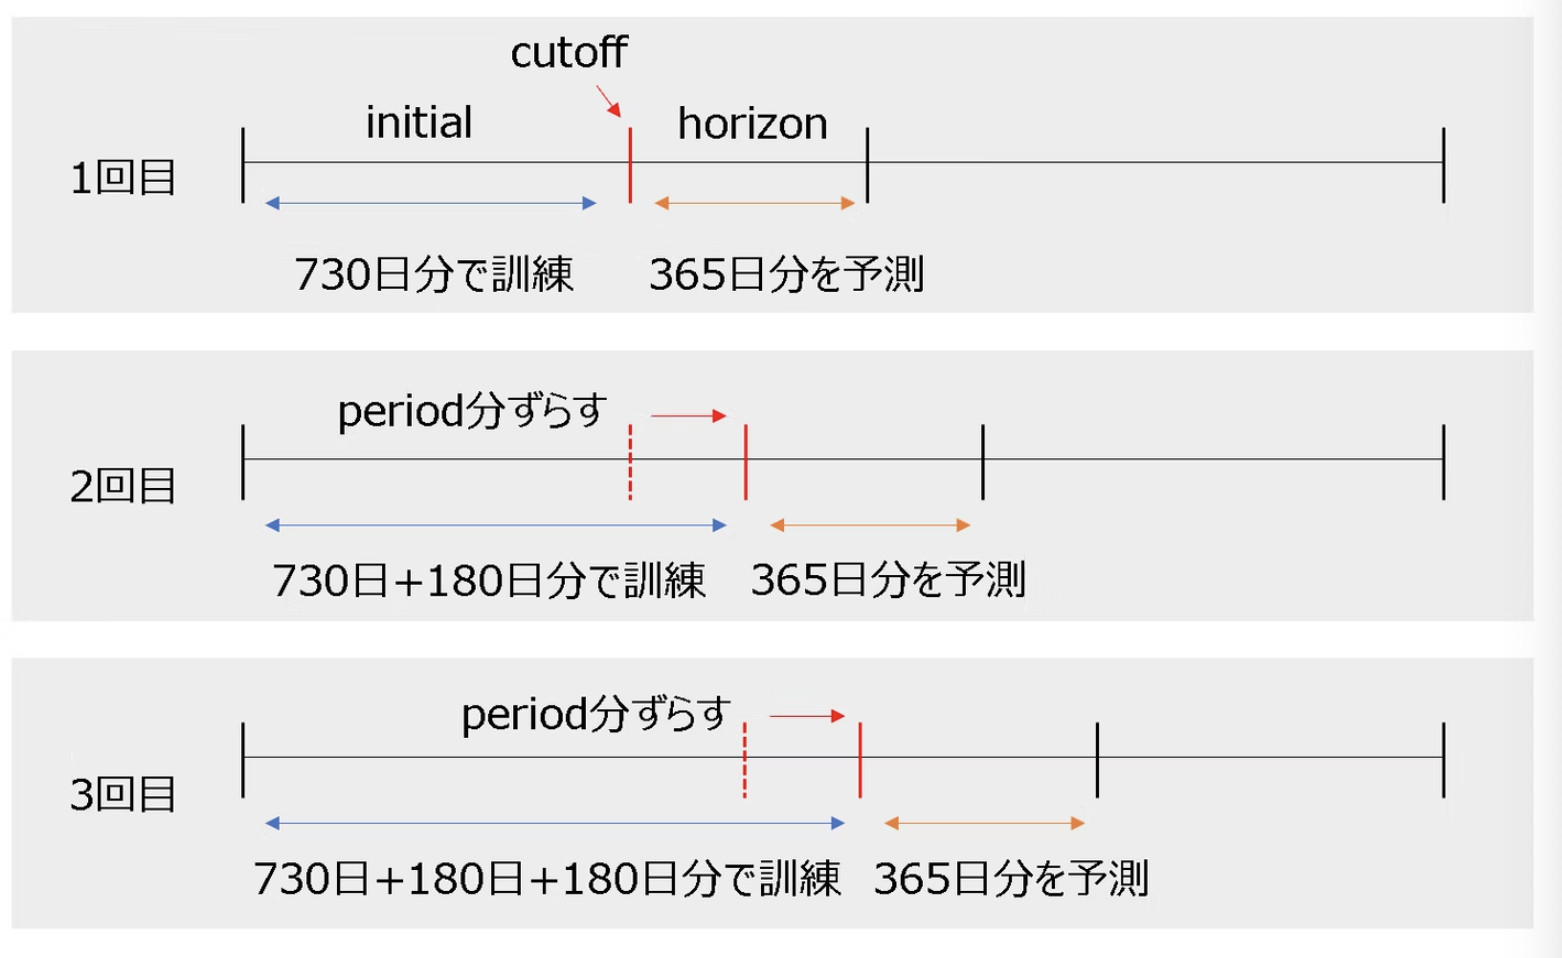

### 結果の確認
`cutoff`は上記のイメージにもあるが、訓練データと予測データの境目となる日付。`y`は実際の値、`yhat`は予測値、`yhat_upper`は予測上限、`yhat_lower`は予測下限。

In [ ]:
df_cv

ds      yhat  yhat_lower  yhat_upper          y     cutoff
0    2010-02-16  8.935660    8.449157    9.422254   8.242493 2010-02-15
1    2010-02-17  8.674739    8.193440    9.151361   8.008033 2010-02-15
2    2010-02-18  8.544324    8.039539    9.060367   8.045268 2010-02-15
3    2010-02-19  8.456727    7.969104    8.943347   7.928766 2010-02-15
4    2010-02-20  8.173637    7.712468    8.690867   7.745003 2010-02-15
...         ...       ...         ...         ...        ...        ...
3983 2016-01-16  8.560971    7.787051    9.349440   7.817223 2015-01-20
3984 2016-01-17  8.943107    8.134466    9.747578   9.273878 2015-01-20
3985 2016-01-18  9.238499    8.431596    9.985971  10.333775 2015-01-20
3986 2016-01-19  9.029833    8.230967    9.817103   9.125871 2015-01-20
3987 2016-01-20  8.872327    8.048734    9.674430   8.891374 2015-01-20

[3988 rows x 6 columns]

### 評価尺度の計算
`oerformance_metrics`メソッドを使用すると各種評価指標を計算できる。`horizon`は予測期間の何日目かを表しており、デフォルトで前半10％は削除されているが、これは`rolling_window`で調整できる。（今回は予測期間が365日分なので37日目から計算が行われている。)

In [ ]:
df_p = performance_metrics(df_cv, rolling_window=0.1)
df_p

horizon       mse      rmse       mae      mape     mdape  coverage
0    37 days  0.490406  0.700290  0.499163  0.057721  0.049062  0.670397
1    38 days  0.495924  0.704219  0.503936  0.058271  0.048961  0.670397
2    39 days  0.519131  0.720508  0.510461  0.058905  0.049427  0.666514
3    40 days  0.527646  0.726392  0.513663  0.059237  0.048961  0.666286
4    41 days  0.536759  0.732638  0.515321  0.059381  0.049062  0.667656
..       ...       ...       ...       ...       ...       ...       ...
324 361 days  1.133651  1.064730  0.863664  0.103204  0.087657  0.512106
325 362 days  1.150865  1.072784  0.871393  0.103934  0.088650  0.508680
326 363 days  1.174856  1.083908  0.880177  0.104857  0.089599  0.502969
327 364 days  1.194918  1.093123  0.889149  0.105948  0.092644  0.494746
328 365 days  1.210690  1.100314  0.899394  0.107130  0.092854  0.486295

[329 rows x 7 columns]

各評価指標の説明

- MSE（mean squared error:平均平方誤差)
- RMSE（root mean squared error: 平均平方誤差の平方根)
- MAE（mean absolute error: 平均絶対誤差)
- MAPE（mean absolute percent error : 平均絶対パーセント誤差)
- coverage（被覆率 : yhat_lower とyhat_upper の間に入っている割合)

MAPEが無難？

### 評価指標の可視化


平均絶対パーセント誤差 MAPE(Mean Average Percent Error)
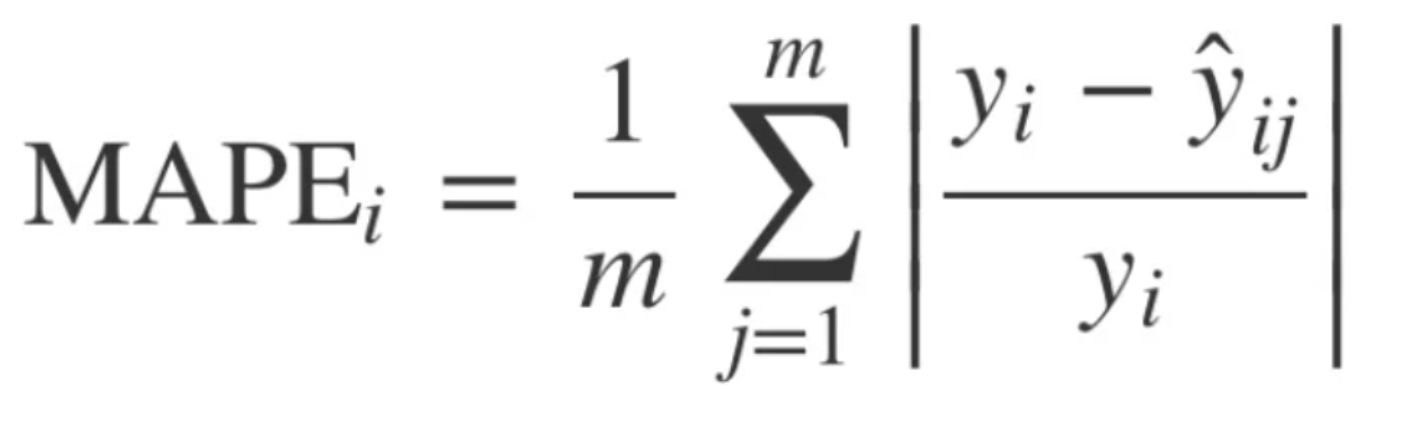
- 予測値が実績値から何%外れているかを表す<br>
→異なる単位の予測を比較できる

SHF(Simulated Historical Forecast)を提案。


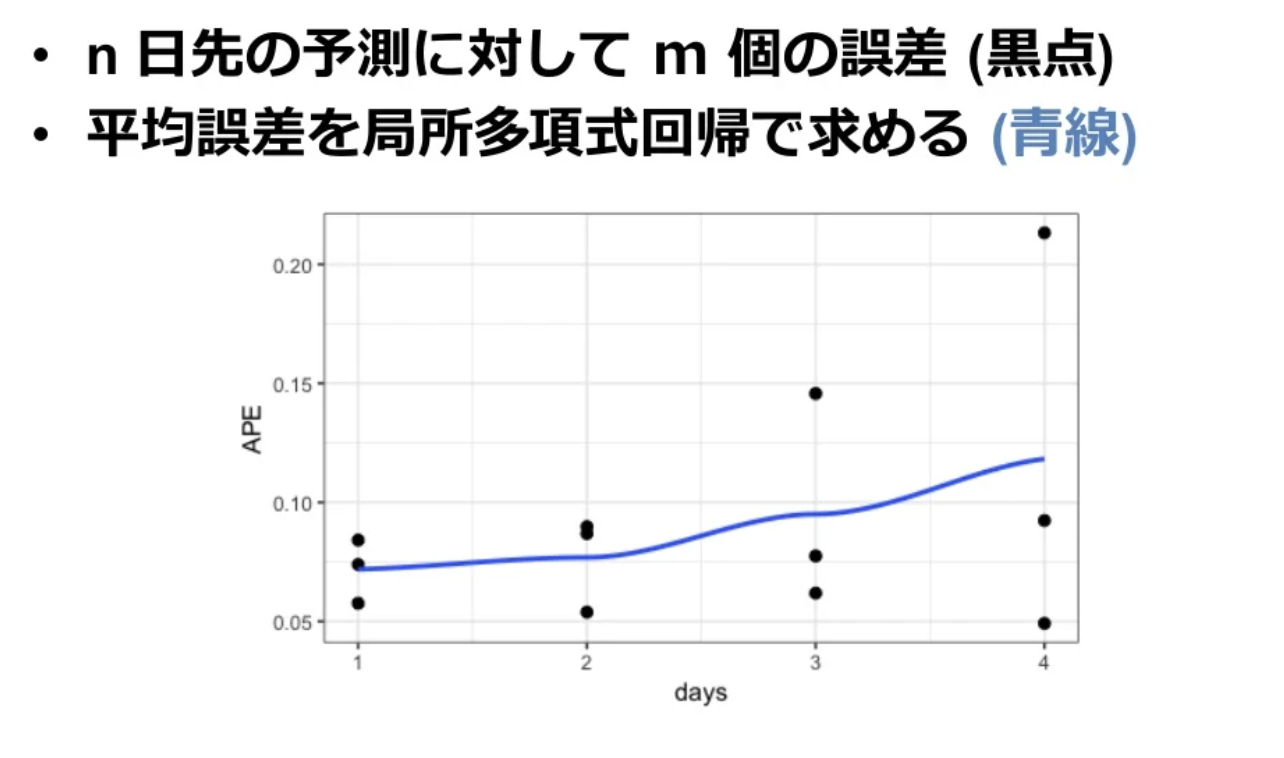

`plot_cross_validation_metric`を使用すると評価指標を可視化することができる。可視化したい指標を`metric`で指定する。

/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



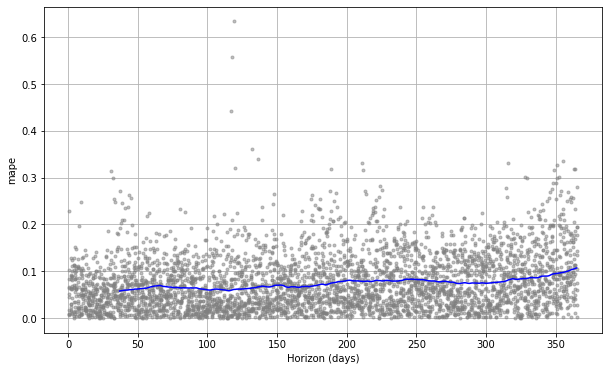

In [ ]:
fig = plot.plot_cross_validation_metric(df_cv, metric='mape')